In [4]:
cat ./data/student.txt

# Attributes for both student-mat.csv (Math course) and student-por.csv (Portuguese language course) datasets:
1 school - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
2 sex - student's sex (binary: "F" - female or "M" - male)
3 age - student's age (numeric: from 15 to 22)
4 address - student's home address type (binary: "U" - urban or "R" - rural)
5 famsize - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
6 Pstatus - parent's cohabitation status (binary: "T" - living together or "A" - apart)
7 Medu - mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
8 Fedu - father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9 Mjob - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or 

# Purpose of research

We need to produce client targetting metrics based on proveded data.

# Results

To improve alcohol sales we need to target audience who

1. Go out more
1. Are males
1. Do skip shool a lot
1. Are more than 18
1. Have mothers without higher education/low education level

Also, not so significantly (some of those features look more like consequences of high alcohol consumption), they

1. Have bad health
1. Have low school grades
1. Study less
1. Have bad relationships with their families
1. Have a big family
1. Have more free time
1. Have mother and father working at services

Feature importances:

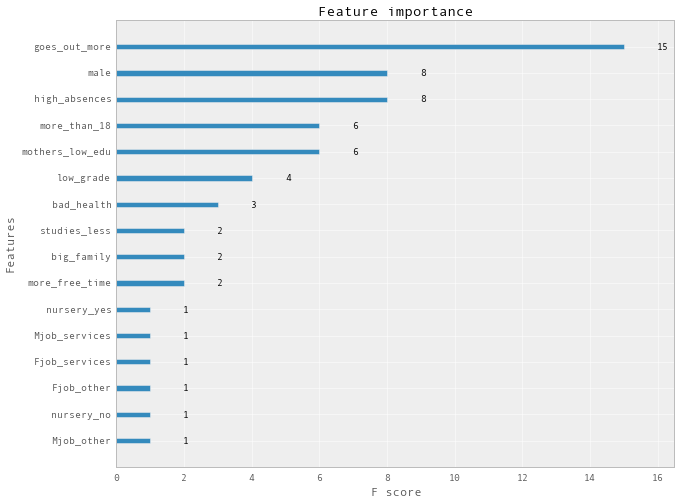

In [56]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
xgb.plot_importance(xgb_clf);

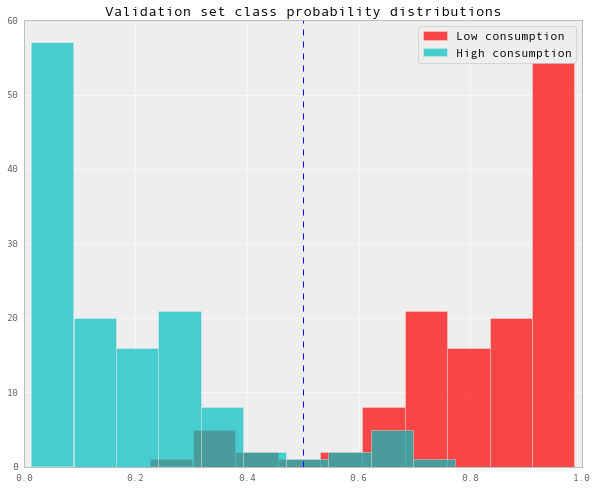

In [151]:
predictions = xgb_clf.predict_proba(x_val)
false_predictions = predictions[:, 0]
true_predictions = predictions[:, 1]

plt.figure()
plt.title("Validation set class probability distributions")

plt.hist(false_predictions, bins = 10, color = 'r', label = 'Low consumption', alpha = 0.7)
plt.hist(true_predictions, bins = 10, color = 'c', label = 'High consumption', alpha = 0.7)
plt.legend();
plt.axvline(0.5, linestyle = 'dashed')

XGBoost was selected as a final model as the most accurate and least variable.

/home/kernelmode/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


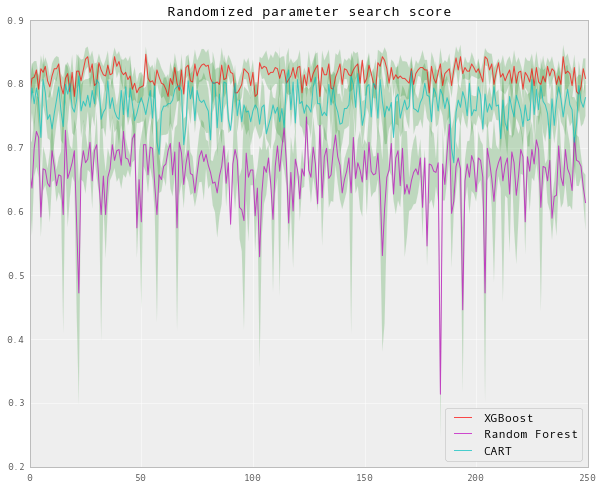

In [149]:
def std_array(random_search_res):
    return np.array([np.std(x) for x in np.array(random_search_res.grid_scores_)[:, 2]]).astype('f')

def plot_std(scores, std, color):
    plt.fill_between(np.arange(250), scores + std, scores - std, alpha=0.2, facecolor = color)

xgb_scores = np.array(xgb_random_search.grid_scores_)[:, 1].astype('f')
cart_scores = np.array(cart_random_search.grid_scores_)[:, 1].astype('f')
rf_scores = np.array(rf_random_search.grid_scores_)[:, 1].astype('f')
xgb_std = std_array(xgb_random_search)
cart_std = std_array(cart_random_search)
rf_std = std_array(rf_random_search)

plt.figure()
plt.title("Randomized parameter search score")

plt.plot(xgb_scores, label = 'XGBoost', color = 'r', alpha = 0.7)
plot_std(xgb_scores, xgb_std, 'g')
plt.plot(cart_scores, label = 'Random Forest', color = 'm', alpha = 0.7)
plot_std(cart_scores, cart_std, 'g')
plt.plot(rf_scores, label = 'CART', color = 'c', alpha = 0.7)
plot_std(rf_scores, rf_std, 'g')
plt.legend(loc = 4)

/home/kernelmode/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


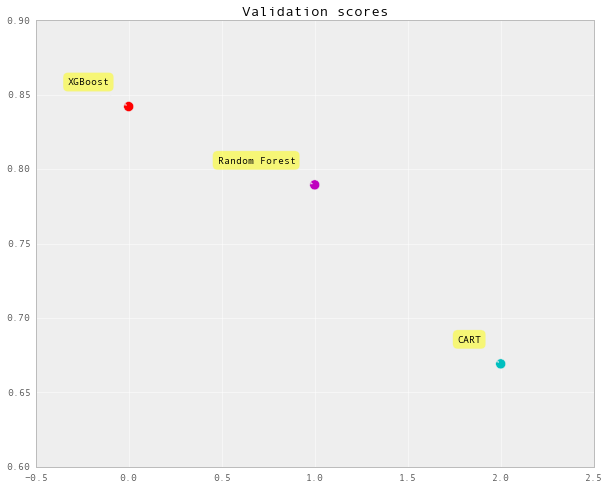

In [148]:
plt.figure()
plt.title("Validation scores")

val_scores = [xgb_val_score, rf_val_score, cart_val_score]
labels = ['XGBoost', 'Random Forest', 'CART']
x = np.arange(3)
plt.scatter(
    x, val_scores, marker = 'o', c = ['r', 'm', 'c'], s = 100)

for label, x, y in zip(labels, x, val_scores):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

# Technical appendix

## Summary data analysys and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from sklearn import cross_validation
from pandas.tools.plotting import scatter_matrix
from IPython.display import display

import pylab


In [2]:
%matplotlib inline
plt.style.use('ggplot')
pd.options.display.mpl_style = 'default'
student_mat = pd.read_csv("./data/student-mat.csv", sep = ";")
student_por = pd.read_csv("./data/student-por.csv", sep = ";")

Kolmogorov-Smirnow test shows that alcohol consumption rates for different courses are very likely to be drawn from the same distribution, so I suppose that we can merge two courses without significantly decreasing alcohol consumption prediction accuracy for each course separately.

In [3]:
display(stats.ks_2samp(student_mat['Walc'], student_por['Walc']))
display(stats.ks_2samp(student_mat['Dalc'], student_por['Dalc']))

Ks_2sampResult(statistic=0.014241969144350608, pvalue=0.99999999971045828)

Ks_2sampResult(statistic=0.0072516627333190087, pvalue=1.0000000000000002)

In [4]:
display(student_por.shape)
display(student_mat.shape)

(649, 33)

(395, 33)

Let's do some preprocessing. Dalc and Walc together can represend alcohol consumption over the whole week. Reducing those features can improve our model since (highly likely) they are correlated 

In [4]:
# TODO: Dalc + Walc processing
def process_alc(data):
    result = data
    result['alc'] = data.apply(lambda row: ((row['Dalc'] * 5.0) + (row['Walc'] * 2.0)) / 7, axis = 1)
    result.drop(['Dalc', 'Walc'], inplace = True, axis = 1)
    return result

process_alc(student_mat);
process_alc(student_por);

In [345]:
student_mat.head(1)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,romantic,famrel,freetime,goout,health,absences,G1,G2,G3,alc
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,4,3,4,3,6,5,6,6,1


Group students who attended both courses and average their features:

In [5]:
students = pd.concat([student_mat, student_por]).groupby(["school",
                                                          "sex",
                                                          "age",
                                                          "address",
                                                          "famsize",
                                                          "Pstatus",
                                                          "Medu",
                                                          "Fedu",
                                                          "Mjob",
                                                          "Fjob",
                                                          "reason",
                                                          "nursery",
                                                          "internet"]).mean().reset_index()

students['alc'] = students['alc'].apply(np.rint)
students.shape

(662, 25)

Not so much students with high alcohol consumption:

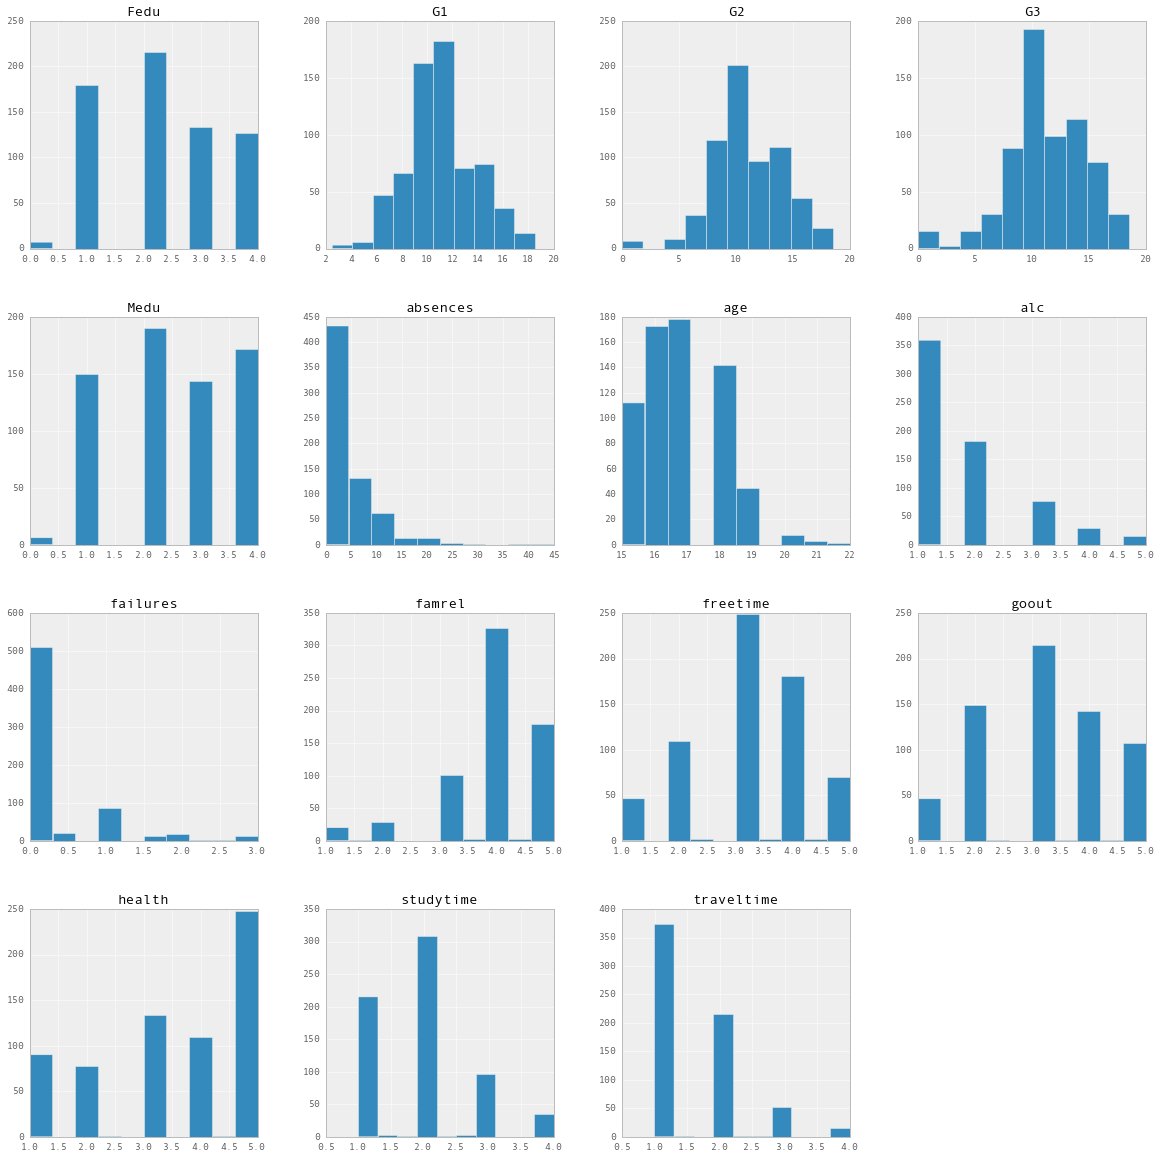

In [7]:
students.hist(figsize=(20, 20));

/home/kernelmode/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


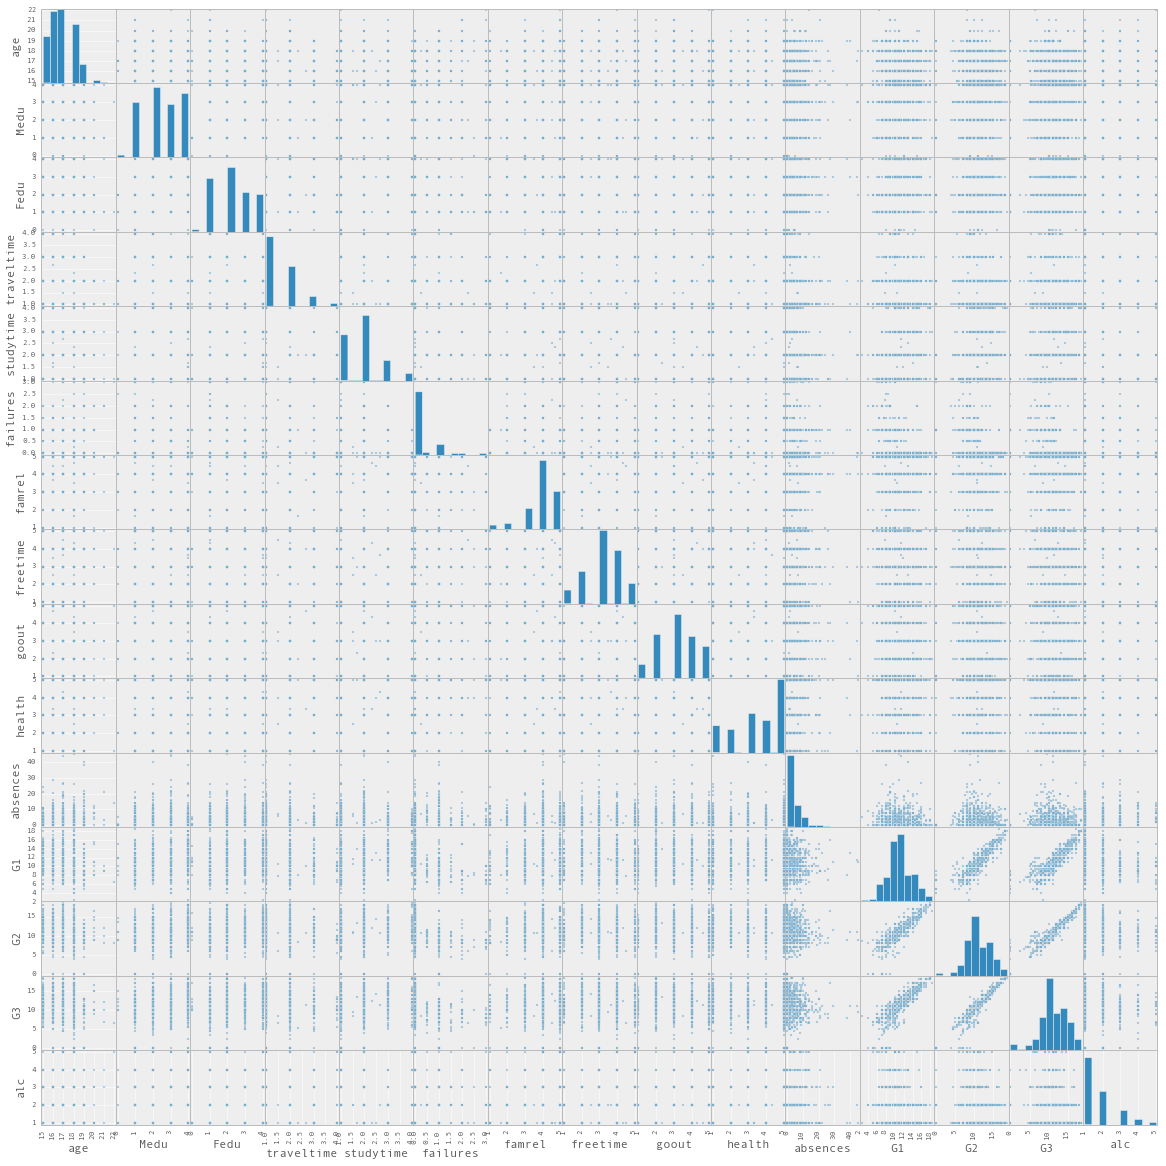

In [8]:
scatter_matrix(students, diagonal = 'hist', figsize=(20, 20));

Feature transformation (for interpretability):

In [6]:
students_transformed = students
students_transformed['male'] = students['sex'] == "M"
students_transformed['rural'] = students['address'] == "R"
students_transformed['big_family'] = students['famsize'] == 'GT3'
students_transformed['parents_together'] = students['Pstatus'] == "T"
students_transformed['studies_less'] = students['studytime'] < 3
students_transformed['more_failures'] = students['failures'] >= 2
students_transformed['bad_relationships'] = students['famrel'] <= 2
students_transformed['more_free_time'] = students['freetime'] > 3
students_transformed['goes_out_more'] = students['goout'] > 4
students_transformed['bad_health'] = students['health'] <= 2
students_transformed['high_absences'] = students['absences'] > (students['absences'].std() * 2)
students_transformed['drinker'] = students['alc'] >= 3
students_transformed['mothers_low_edu'] = students['Medu'] <= 3
students_transformed['fathers_low_edu'] = students['Fedu'] <= 3
students_transformed['more_than_18'] = students['age'] > 18
students_transformed['long_road'] = students['traveltime'] >= 3

sum_grade = students['G1'] + students['G2'] + students['G3']
mean_grade = (sum_grade) / 3 
students_transformed['low_grade'] = mean_grade <= (mean_grade.mean() + mean_grade.std())

students_transformed.drop(['sex', 
                           'address', 
                           'famsize', 
                           'Pstatus', 
                           'studytime', 
                           'failures', 
                           'famrel', 
                           'freetime', 
                           'goout', 
                           'health',
                           'absences',
                           'alc',
                           'G1',
                            'G2',
                            'G3',
                           'Medu',
                           'Fedu',
                           'age',
                           'traveltime'], axis = 1, inplace = True)

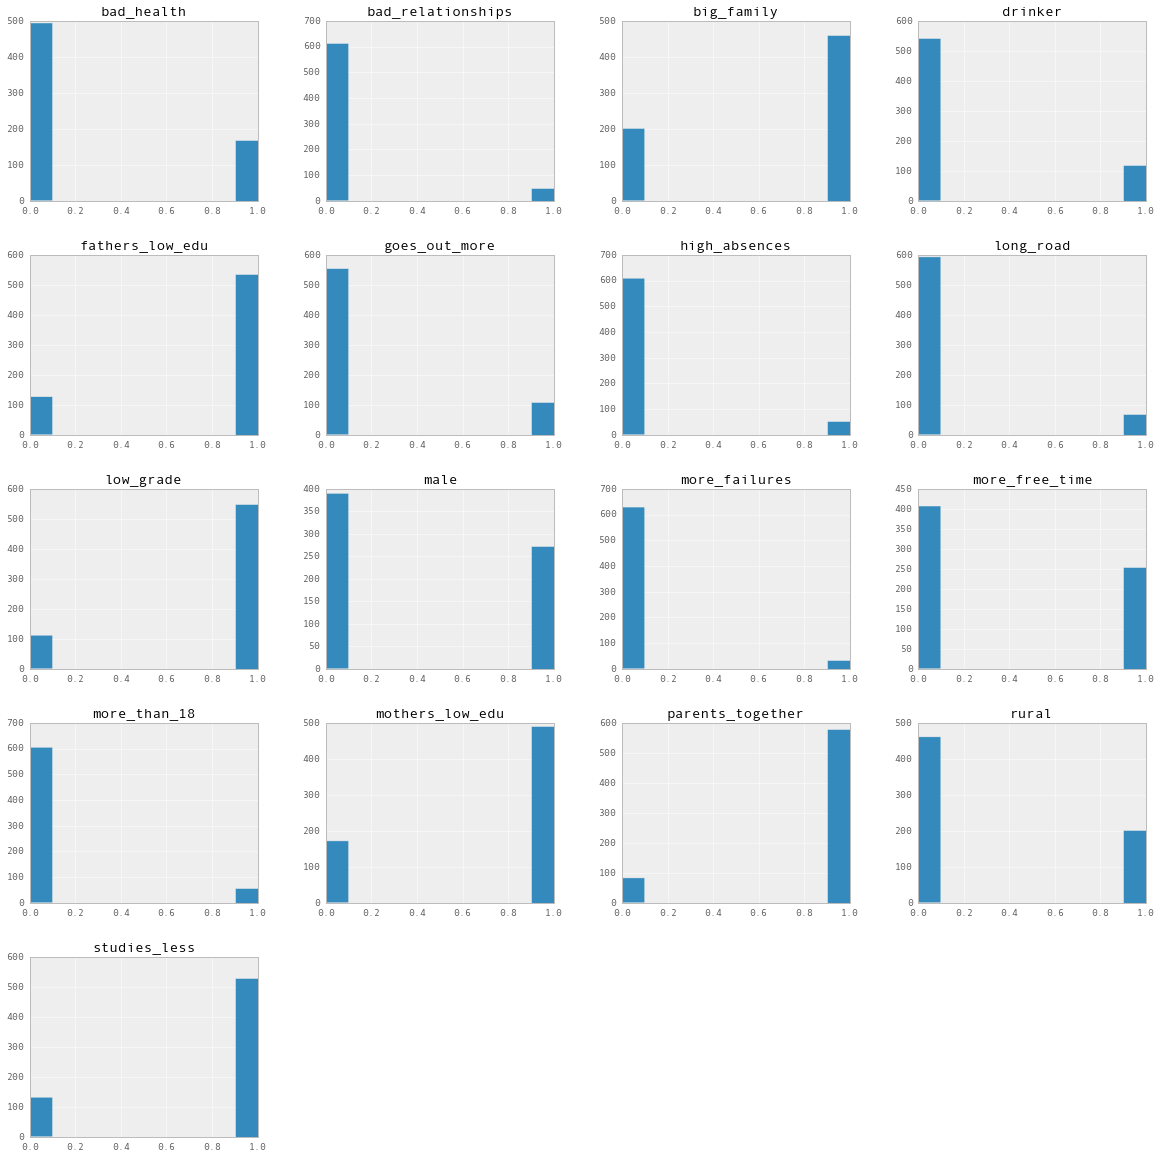

In [10]:
students_transformed.hist(figsize=(20, 20));

## Model evaluation

We get around 70% accuracy with dummy classifier

In [8]:
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint

data = students_transformed.drop('drinker', axis = 1)
data = pd.get_dummies(data)
target = students_transformed['drinker']
x_train, x_val, y_train, y_val = cross_validation.train_test_split(data, target, test_size=0.2, random_state=123, stratify = target)

d_clf = DummyClassifier()
cross_val_score(d_clf, data, target).mean()

0.69788424788424785

Now let's try CART:

In [97]:
from sklearn import tree

param_dist = {
    "criterion" : ["gini", "entropy"],
    "splitter" : ["best", "random"],
    "max_features" : ["sqrt", "log2", None],
    "max_depth" : sp_randint(1, 21),
    "min_samples_split": sp_randint(1, 21),
    "min_samples_leaf": sp_randint(1, 21),
}

clf = tree.DecisionTreeClassifier(class_weight = "balanced")
n_iter_search = 250
cart_random_search = RandomizedSearchCV(clf, param_distributions = param_dist,
                                   n_iter = n_iter_search, random_state = 123)
cart_random_search.fit(x_train, y_train)
print("Best randomized search score - %s" % cart_random_search.best_score_)

clf = cart_random_search.best_estimator_
cart_val_score = clf.score(x_val, y_val)
print("Validation score - %s" % cart_val_score)

Best randomized search score - 0.748582230624
Validation score - 0.669172932331


Random Forests:

In [98]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(class_weight = "balanced")
rf_param_dist ={"n_estimators" : np.arange(10, 100, 10),
                  "max_depth": sp_randint(1, 31),
                  "max_features": sp_randint(1, 11),
                  "min_samples_split": sp_randint(1, 11),
                  "min_samples_leaf": sp_randint(1, 11),
                  "max_features" : ["auto", "sqrt", "log2"],
                  "criterion": ["gini", "entropy"]}

# We could use OOB here, but randomized search will be faster for prototyping. 
# The benefit of using OOB would be the unnecessarity of splitting the data for validation purposes
n_iter_search = 250
rf_random_search = RandomizedSearchCV(rf_clf, param_distributions = rf_param_dist,
                                   n_iter = n_iter_search, random_state = 123)
rf_random_search.fit(x_train, y_train)
rf_clf = rf_random_search.best_estimator_
rf_val_score = rf_clf.score(x_val, y_val)
print("Best randomized search score - %s" % rf_random_search.best_score_)
print("Validation score - %s" % rf_val_score)

Best randomized search score - 0.822306238185
Validation score - 0.789473684211


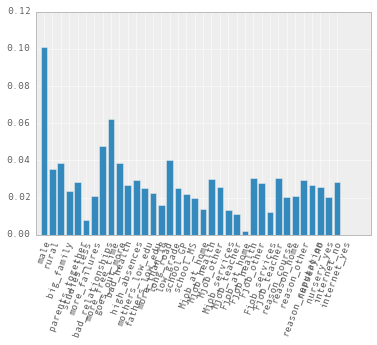

In [15]:
ax = plt.subplot(111)
width = 0.8
names = x_train.columns
bins = list(map(lambda x: x - width / 2, range(1, len(rf_clf.feature_importances_) + 1)))
ax.bar(bins, rf_clf.feature_importances_, width = width)
ax.set_xticks(list(map(lambda x: x, range(1, len(rf_clf.feature_importances_) + 1))))
ax.set_xticklabels(names,rotation = 70)

plt.show()

XGBoost seems to perform better

In [99]:
import xgboost as xgb
from scipy.stats import uniform

xgb_param_dist = {"n_estimators" :  np.arange(10, 200, 10),
                  "max_depth": sp_randint(2, 31),
                  "learning_rate" : uniform(loc = 0.01, scale=0.2),
                  "colsample_bytree" : uniform(loc = 0.3, scale = 0.5)}

xgb_clf = xgb.XGBClassifier()
n_iter_search = 250
xgb_random_search = RandomizedSearchCV(xgb_clf, param_distributions = xgb_param_dist,
                                   n_iter = n_iter_search, random_state = 123)
xgb_random_search.fit(x_train, y_train)
xgb_clf = xgb_random_search.best_estimator_
xgb_val_score = xgb_clf.score(x_val, y_val)
print("Best randomized search score - %s" % xgb_random_search.best_score_)
print("Validation score - %s" % xgb_val_score)

Best randomized search score - 0.848771266541
Validation score - 0.84962406015


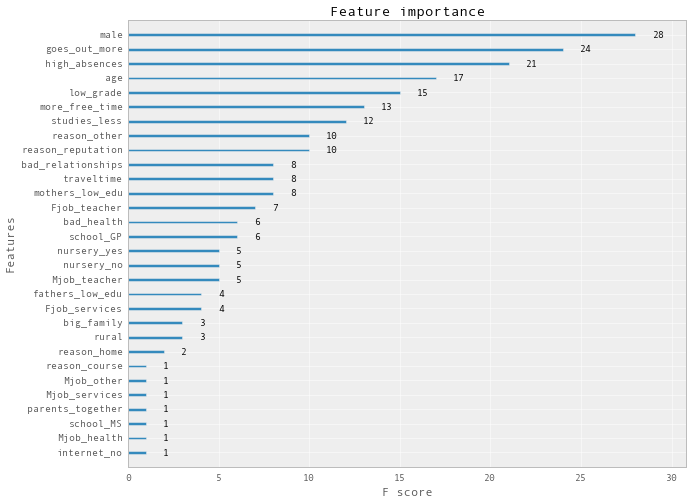

In [647]:
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
xgb.plot_importance(xgb_clf);

Now let's try to do feature selection.

In [100]:
data = students_transformed.drop(['drinker', 'internet', 'school', 'parents_together', 'reason'], axis = 1)
data = pd.get_dummies(data)
target = students_transformed['drinker']
x_train, x_val, y_train, y_val = cross_validation.train_test_split(data, target, test_size=0.2, 
                                                                   random_state=123, stratify = target)

n_iter_search = 250
xgb_random_search = RandomizedSearchCV(xgb_clf, param_distributions = xgb_param_dist,
                                   n_iter = n_iter_search, random_state = 123)
xgb_random_search.fit(x_train, y_train)
xgb_clf = xgb_random_search.best_estimator_
xgb_val_score = xgb_clf.score(x_val, y_val)
print("Best randomized search score - %s" % xgb_random_search.best_score_)
print("Validation score - %s" % xgb_val_score)

Best randomized search score - 0.846880907372
Validation score - 0.842105263158


A little improvement over the last model.